In [2]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Dense, Flatten, LSTM, TimeDistributed, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import cv2
import os
import datetime 
import time

In [6]:
# Define the size of the frames
frame_size = (224, 224)

# Define the number of frames per sequence
frames_per_sequence = 16

# Define the batch size
batch_size = 32

# Define the number of epochs
num_epochs = 10
# num_epochs = 2


# Define the path to the video dataset directory
data_dir = "Dataset"

# Define the list of categories
categories = ["Fighting","Kidnap", "Murder", "Robbery", "Shoplifting"]

In [7]:
# Load VGG16 model without the top layers
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(frame_size[0], frame_size[1], 3))

# Freeze the layers
for layer in vgg16.layers:
    layer.trainable = False

# Define the LSTM model
model = Sequential()
model.add(TimeDistributed(vgg16, input_shape=(frames_per_sequence, frame_size[0], frame_size[1], 3)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(256, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

# Compile the model
optimizer = Adam(learning_rate=1e-4, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

##### without pickle

In [7]:
# Load the dataset
data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)

        # Initialize a list to store the frames
        frames = []

        # Open the video file
        cap = cv2.VideoCapture(filepath)

        # Loop through the frames and add them to the list
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Convert the frame to an array and normalize the pixel values
            frame = img_to_array(frame)
            frame = frame.astype('float32') / 255.0

            frames.append(frame)

        # Release the video file
        cap.release()

        # If the number of frames is less than the required number, pad the list with zeros
        if len(frames) < frames_per_sequence:
            frames.extend([np.zeros(frame_size) for _ in range(frames_per_sequence - len(frames))])

        # Keep only the required number of frames
        frames = frames[:frames_per_sequence]

        # Add the list of frames to the data list and the corresponding label to the labels list
        data.append(frames)
        labels.append(label)


In [12]:
# Convert the data and labels lists to arrays
data = np.array(data)
labels = np.array(labels)

# Convert the labels to categorical format
labels = to_categorical(labels, num_classes=len(categories))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


##### for pickle file

In [8]:
import pickle

# Load the dataset
data = []
labels = []

for category in categories:
    path = os.path.join(data_dir, category)
    label = categories.index(category)

    for filename in os.listdir(path):
        filepath = os.path.join(path, filename)

        # Initialize a list to store the frames
        frames = []

        # Open the video file
        cap = cv2.VideoCapture(filepath)

        # Loop through the frames and add them to the list
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # Resize the frame
            frame = cv2.resize(frame, frame_size)

            # Convert the frame to an array and normalize the pixel values
            frame = img_to_array(frame)
            frame = frame.astype('float32') / 255.0

            frames.append(frame)

        # Release the video file
        cap.release()

        # If the number of frames is less than the required number, pad the list with zeros
        if len(frames) < frames_per_sequence:
            frames.extend([np.zeros(frame_size) for _ in range(frames_per_sequence - len(frames))])

        # Keep only the required number of frames
        frames = frames[:frames_per_sequence]

        # Add the list of frames to the data list and the corresponding label to the labels list
        data.append(frames)
        labels.append(label)

# Save the data and labels to a pickle file
with open('data.pkl', 'wb') as f:
    pickle.dump((data, labels), f)


In [ ]:
import numpy as np
import pickle

# Load the data and labels from the pickle file
with open('data.pkl', 'rb') as f:
    data, labels = pickle.load(f)

# Convert the data and labels lists to arrays
data = np.array(data)
labels = np.array(labels)

# Convert the labels to categorical format
labels = to_categorical(labels, num_classes=len(categories))

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)


#### fit

In [13]:
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, validation_data=(X_test, y_test))

Epoch 1/2
4/4 [==============================] - 815s 218s/step - loss: 0.7363 - accuracy: 0.5304 - val_loss: 0.6464 - val_accuracy: 0.5517
Epoch 2/2
4/4 [==============================] - 784s 209s/step - loss: 0.4917 - accuracy: 0.8000 - val_loss: 0.4593 - val_accuracy: 0.7586


In [14]:
loss, accuracy = model.evaluate(X_test, y_test)

print("Test Loss: ", loss)
print("Test Accuracy: ", accuracy)

1/1 [==============================] - 135s 135s/step - loss: 0.4593 - accuracy: 0.7586
Test Loss:  0.45931559801101685
Test Accuracy:  0.7586206793785095


In [15]:
model.save("try1_model.h5")

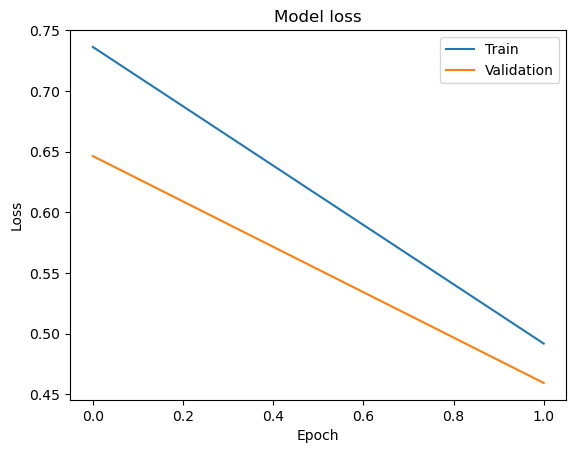

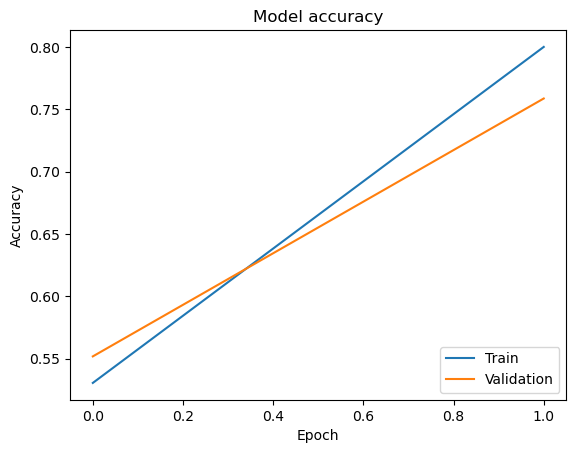

In [16]:
import matplotlib.pyplot as plt


# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()


In [39]:
import cv2
import numpy as np

# Load the video file and extract frames
cap = cv2.VideoCapture('trydataset\Fighting\v_Fighting_g002_c001.mp4')
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame = cv2.resize(frame, (224, 224))
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
    frame = frame.astype('float32') / 255.0 # Normalize pixel values
    frames.append(frame)
cap.release()

# Pad or truncate frames to desired length
frames_per_sequence = 16
if len(frames) < frames_per_sequence:
    frames.extend([np.zeros((224, 224, 3)) for _ in range(frames_per_sequence - len(frames))])
else:
    frames = frames[:frames_per_sequence]

# Convert frames to numpy array
frames = np.array(frames)

# Add batch dimension and change number of channels to 3
frames = np.expand_dims(frames, axis=0)
frames = np.expand_dims(frames,  axis=-1)

# Make prediction
predicted_probs = model.predict(frames)

# Get the index of the category with the highest probability
pred_idx = np.argmax(predicted_probs)
predicted_category = categories[np.argmax(predicted_probs)]

# Get the corresponding probability
prob = predicted_probs[0][pred_idx]

# Print the predicted category with the corresponding probability
print(f"Predicted category: {predicted_category}")
print(f"Probability: {prob:.2f}")



1/1 [==============================] - 2s 2s/step
Predicted category: Kidnap
Probability: 0.58


In [56]:
def predict_category(video_path):
    # Load the video file and extract frames
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (224, 224))
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) # Convert to RGB
        frame = frame.astype('float32') / 255.0 # Normalize pixel values
        frames.append(frame)
    cap.release()

    # Pad or truncate frames to desired length
    frames_per_sequence = 16
    if len(frames) < frames_per_sequence:
        frames.extend([np.zeros((224, 224, 3)) for _ in range(frames_per_sequence - len(frames))])
    else:
        frames = frames[:frames_per_sequence]

    # Convert frames to numpy array
    frames = np.array(frames)

    # Add batch dimension and change number of channels to 3
    frames = np.expand_dims(frames, axis=0)
    frames = np.expand_dims(frames,  axis=-1)

    # Make prediction
    predicted_probs = model.predict(frames)

    # Get the index of the category with the highest probability
    pred_idx = np.argmax(predicted_probs)
    predicted_category = categories[np.argmax(predicted_probs)]

    # Get the corresponding probability
    prob = predicted_probs[0][pred_idx]

    # Print the predicted category with the corresponding probability
    print(f"Predicted category: {predicted_category}")
    print(f"Probability: {prob:.2f}")


    output_directory_path = 'output_prediction'
    predicted_output_directory_path = os.path.join(output_directory_path, predicted_category)

    # Create the directory if it doesn't exist.
    if not os.path.exists(predicted_output_directory_path):
        os.makedirs(predicted_output_directory_path)

    timestamp = time.strftime('%Y%m%d_%H%M%S')

    # Write the predicted action and confidence to the output file in the predicted output directory.
    output_file_path = os.path.join(predicted_output_directory_path, f'{predicted_category}_output_{timestamp}.txt')

    # Write the predicted action and confidence to a file in the output directory corresponding to the predicted class.
    # output_file_path = os.path.join("output_file", f'{predicted_class_name}.txt')


    # Get the current time
    now = datetime.datetime.now()
    # Format the timestamp in the desired format
    date_time_str = now.strftime("Date %Y-%m-%d, Time %H:%M:%S")


    # Write the predicted action and confidence to the output file.
    with open(output_file_path, 'w') as f:
        f.write(f'Action Predicted: {predicted_category}\nAccuracy: {prob:.2f}\n{date_time_str}')
        



In [57]:
predict_category("sql demo\v_Robbery_g001_c001.mp4")

1/1 [==============================] - 2s 2s/step
Predicted category: Kidnap
Probability: 0.58
